 # When Can We Reuse a Calibration Set for Multiple Conformal Predictions?
 
 
 Experiments with [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). 


### Import TensorFlow

In [1]:
%matplotlib inline
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


import numpy as np

np.random.seed(42)
tf.random.set_seed(2025)

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


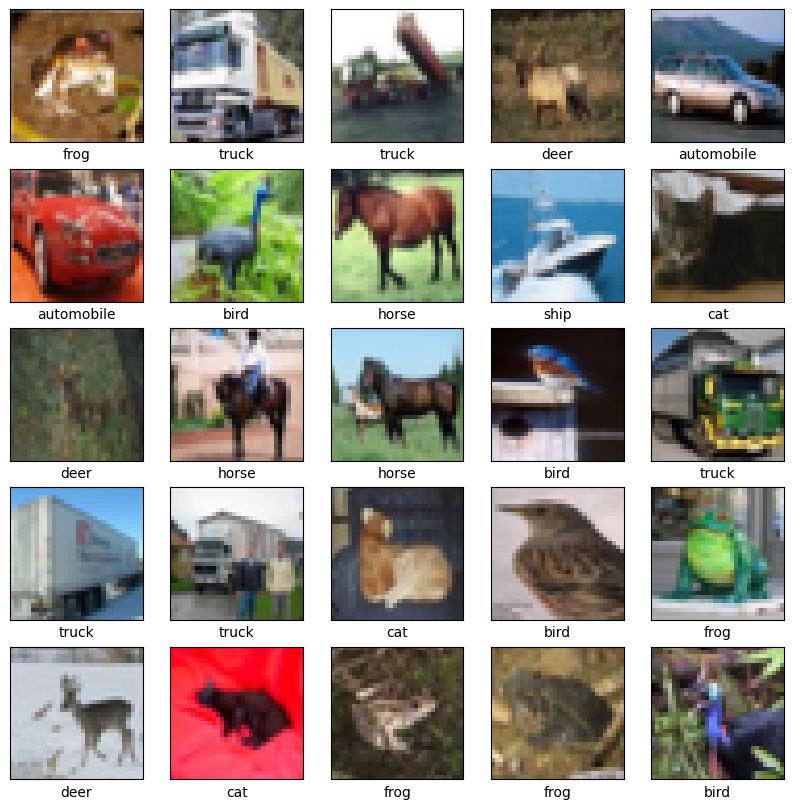

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Build a deep learning machine learning model

Build a `tf.keras.Sequential` model:

### Create the convolutional base



As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [4]:


model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10)
])




Let's display the architecture of your model so far:

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [6]:
predictions = model(train_images[:1]).numpy()
predictions

array([[ 0.01100583,  0.00139596,  0.00597669,  0.03814773,  0.00324591,
        -0.00466688, -0.00818437, -0.00791532, -0.03011931, -0.00593732]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class:

In [7]:
tf.nn.softmax(predictions).numpy()

array([[0.10106307, 0.10009652, 0.10055608, 0.10384368, 0.10028187,
        0.09949149, 0.09914214, 0.09916882, 0.09699114, 0.09936517]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.
<br><br>

Define a loss function for training using `losses.SparseCategoricalCrossentropy`:

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [9]:
loss_fn(train_labels[:1], predictions).numpy()

2.3112006

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

### Compile and train the model

In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])



In [11]:
history = model.fit(train_images, train_labels, epochs=50, 
                    validation_data=(test_images, test_labels))

Epoch 1/50
1563/1563 [==============================] - 11s 6ms/step - loss: 1.5295 - accuracy: 0.4671 - val_loss: 1.1371 - val_accuracy: 0.5964
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0177 - accuracy: 0.6442 - val_loss: 0.9300 - val_accuracy: 0.6801
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8444 - accuracy: 0.7088 - val_loss: 0.8144 - val_accuracy: 0.7135
Epoch 4/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7480 - accuracy: 0.7431 - val_loss: 0.6905 - val_accuracy: 0.7624
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6818 - accuracy: 0.7668 - val_loss: 0.7832 - val_accuracy: 0.7312
Epoch 6/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6209 - accuracy: 0.7903 - val_loss: 0.6046 - val_accuracy: 0.7939
Epoch 7/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5801 - accuracy: 0.8022 - val_loss: 0.5922 - val_accur

### Evaluate the model

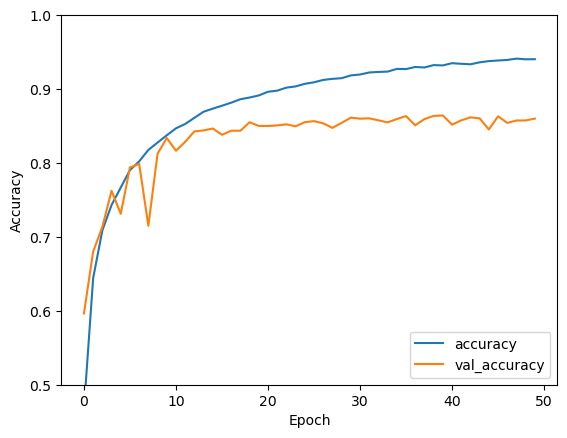

313/313 - 1s - loss: 0.5107 - accuracy: 0.8600 - 1s/epoch - 4ms/step


In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [13]:
print(test_acc)

0.8600000143051147


The `Model.evaluate` method checks the model's performance, usually on a [validation set](https://developers.google.com/machine-learning/glossary#validation-set) or [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [14]:
model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.5107 - accuracy: 0.8600 - 1s/epoch - 4ms/step


[0.510662853717804, 0.8600000143051147]

Your simple CNN has achieved a test accuracy of over 86%. 

To save your trained model in TensorFlow/Keras:

In [15]:
# Save the entire model to a file
model.save('my_cifar10_model.h5')

To load the model later and use it:

from tensorflow.keras.models import load_model

# Load the model from file
loaded_model = load_model('my_cifar10_model.h5')

# Use it for prediction or evaluation
loaded_model.evaluate(test_images, test_labels)
predictions = loaded_model.predict(test_images)

### Probability model

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [17]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [18]:
probability_model(test_images[:2])

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[1.1781399e-06, 8.7414726e-08, 1.7727949e-05, 9.7917753e-01,
        1.8418343e-06, 1.7498493e-02, 3.3003257e-03, 1.4794333e-06,
        1.2457757e-06, 2.5312666e-08],
       [6.8567840e-10, 2.6353393e-05, 1.3694715e-11, 6.9801023e-12,
        1.2814043e-13, 1.2396379e-11, 1.4067691e-11, 7.5159844e-13,
        9.9997354e-01, 9.8888570e-08]], dtype=float32)>

Let us see examples from the test set with wrong predictions

In [19]:
predictions_on_tests = np.argmax(probability_model(test_images), axis=1)
predictions_on_tests

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [20]:
sum(predictions_on_tests != test_labels.flatten()) 

1399

In [21]:
wrong_predictions = test_images[predictions_on_tests != test_labels.flatten()]
wrong_predictions.shape

(1399, 32, 32, 3)

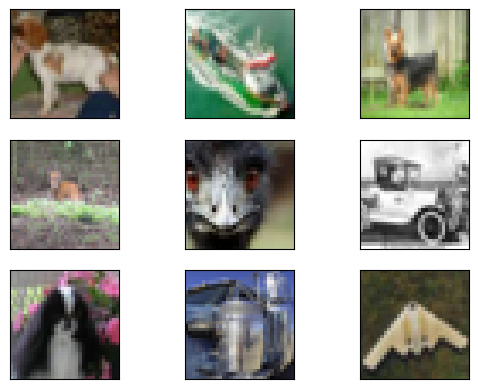

In [44]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(wrong_predictions[i], cmap=plt.get_cmap('gray'))
plt.show()

This will show 9 misclassified images, each with the predicted and true class names.

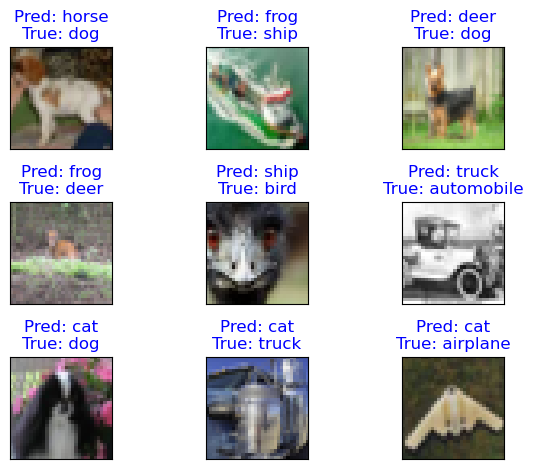

In [41]:
# Find indices of wrong predictions
wrong_indices = np.where(predictions_on_tests != test_labels.flatten())[0]

#plt.figure(figsize=(12, 6))
for i in range(9):
    idx = wrong_indices[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.xticks([])
    plt.yticks([])
    pred_label = class_names[predictions_on_tests[idx]]
    true_label = class_names[test_labels[idx][0]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color="blue")
plt.tight_layout()
plt.show()

<br><br>

### CIFAR10 and Inductive E-test predictor with simple loss function $\lambda$ = 1-probability
--------------

So, we trained our model on the training data, and now let us forget about the training data.

We devide test data into two parts: `images_calibrate_cp` and `images_test_cp`,
 with corresponding labels `labels_calibrate_cp` and `labels_test_cp`

In [50]:
from sklearn.model_selection import train_test_split



images_calibrate_cp, images_test_cp, labels_calibrate_cp , labels_test_cp = train_test_split(test_images, test_labels,
                                                    test_size=0.5,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=test_labels)

In [51]:
images_calibrate_cp.shape, images_test_cp.shape, labels_calibrate_cp.shape, labels_test_cp.shape

((5000, 32, 32, 3), (5000, 32, 32, 3), (5000, 1), (5000, 1))

Let us look into performance of our model on `image_calibrate_cp, image_test_cp`:

In [52]:
model.evaluate(images_calibrate_cp, labels_calibrate_cp , verbose=2)

157/157 - 1s - loss: 0.5077 - accuracy: 0.8602 - 1s/epoch - 7ms/step


[0.5076837539672852, 0.8601999878883362]

In [53]:
model.evaluate(images_test_cp, labels_test_cp , verbose=2)

157/157 - 0s - loss: 0.5136 - accuracy: 0.8598 - 320ms/epoch - 2ms/step


[0.513642430305481, 0.8597999811172485]

<br>

The non-conformity scores for `image_calibrate_cp` can be calculated in advance by using the 
$(1 - probability)^p$ function:

In [59]:
# alpha scores for calibrating set
p = 1


A_calibrate = (1 - (probability_model(images_calibrate_cp)).numpy())**p
A_calibrate.shape



(5000, 10)

In [60]:
alpha_calibrate = np.array([A_calibrate[i, labels_calibrate_cp[i]] for i in range(len(labels_calibrate_cp))])
alpha_calibrate.shape

(5000, 1)

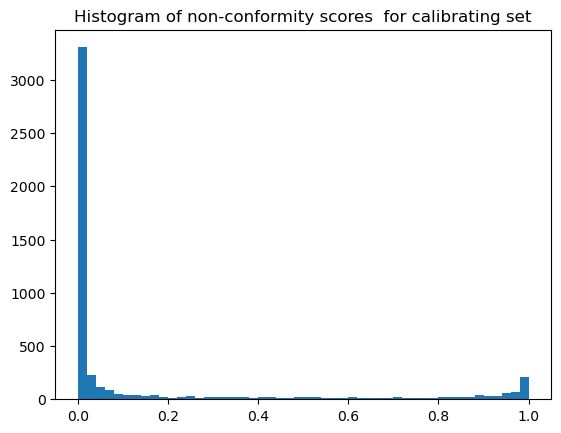

In [62]:
import matplotlib.pyplot as plt
plt.hist(alpha_calibrate, bins = 50)
plt.title('Histogram of non-conformity scores  for calibrating set')
plt.show()

In [63]:
mean_alpha_calibrate = np.mean(alpha_calibrate,axis=0)
mean_alpha_calibrate

array([0.15795493], dtype=float32)

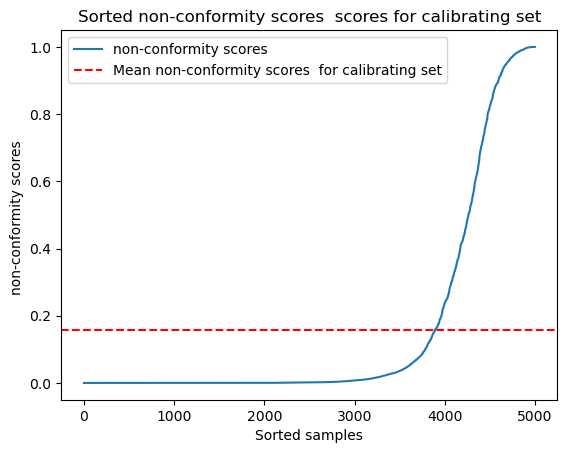

In [67]:
plt.plot(range(len(alpha_calibrate)), np.sort(alpha_calibrate[:,0]), label='non-conformity scores ')
plt.axhline(y=mean_alpha_calibrate, color='red', linestyle='--', label='Mean non-conformity scores  for calibrating set')
plt.ylabel('non-conformity scores ')
plt.xlabel('Sorted samples')
plt.title('Sorted non-conformity scores  scores for calibrating set')       
plt.legend()
plt.show()

## Analysis

#### Without Hoeffding correction

In [ ]:
# Correction factor
t_epsilon = 0
#t_epsilon = 0.02



A_test_cp = (1 - (probability_model(images_test_cp)).numpy())**p
A_test_cp.shape

(5000, 10)

In [94]:
alpha_tilde = 0.2
threshold = (mean_alpha_calibrate + t_epsilon)/alpha_tilde
threshold

array([0.78977466], dtype=float32)

In [95]:
A_test_cp < threshold

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       ...,
       [False,  True, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False]])

In [96]:
list_cp0 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 0]
list_cp1 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 1]
list_cp2 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 2]
list_cp3 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 3]
list_cp4 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 4]
list_cp5 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] > 4]

In [97]:
print("Examples without labels:  ",len(list_cp0))
print("Examples with one  label:  ",len(list_cp1))
print("Examples with two  labels:  ",len(list_cp2))

print("Examples with three  labels:  ",len(list_cp3))
print("Examples with four  labels:  ",len(list_cp4))
print("Examples with more than four  labels:  ",len(list_cp5))

Examples without labels:   0
Examples with one  label:   4464
Examples with two  labels:   501
Examples with three  labels:   34
Examples with four  labels:   1
Examples with more than four  labels:   0


### Examples with labels

Let us see some examples of images that cant have reliable labels:

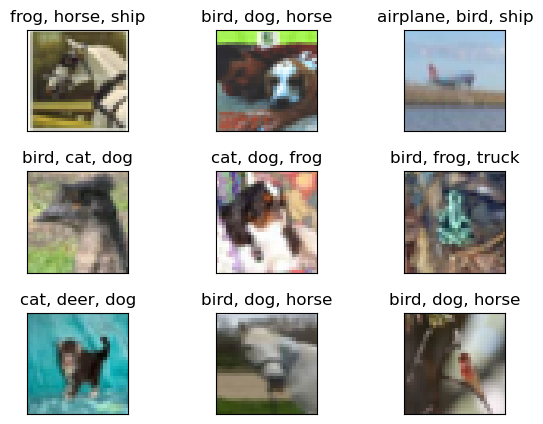

In [98]:
for i in range(9):
  ax1 = plt.subplot(330 + 1 + i)
  ll = [x for x in np.where((A_test_cp[list_cp3[i]] < threshold))][0]
  ll = ", ".join([class_names[x] for x in ll])
  ax1.title.set_text(ll)
  ax1.set_xticks([])
  ax1.set_yticks([])
  plt.imshow(images_test_cp[list_cp3[i]], cmap=plt.get_cmap('gray'))
  #plt.grid(False)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4) 


plt.show()

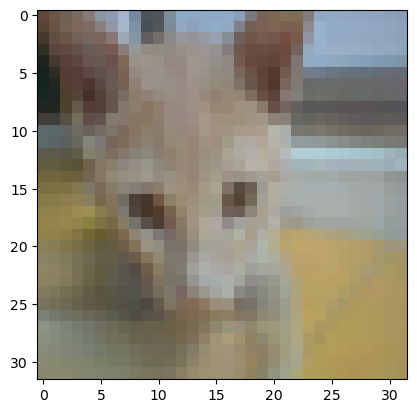

In [99]:
plt.imshow(images_test_cp[list_cp4[0]], cmap=plt.get_cmap('gray'))
plt.show()

In [100]:
ll = [x for x in np.where((A_test_cp[list_cp4[0]] < threshold))][0]
ll = ", ".join([class_names[x] for x in ll])
ll

'cat, deer, dog, horse'

### With Hoeffding's correction

In [102]:
# Correction factor
#t_epsilon = 0
t_epsilon = 0.02



A_test_cp = (1 - (probability_model(images_test_cp)).numpy())**p
A_test_cp.shape

(5000, 10)

In [103]:
alpha_tilde = 0.2
threshold = (mean_alpha_calibrate + t_epsilon)/alpha_tilde
threshold

array([0.8897746], dtype=float32)

In [104]:
A_test_cp < threshold

list_cp0 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 0]
list_cp1 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 1]
list_cp2 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 2]
list_cp3 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 3]
list_cp4 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 4]
list_cp5 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] == 5]
list_cp6 = [i for i in range(len(labels_test_cp)) if np.sum(A_test_cp < threshold, axis =1)[i] > 5]



In [105]:
print("Examples without labels:  ",len(list_cp0))
print("Examples with one  label:  ",len(list_cp1))
print("Examples with two  labels:  ",len(list_cp2))

print("Examples with three  labels:  ",len(list_cp3))
print("Examples with four  labels:  ",len(list_cp4))
print("Examples with five  labels:  ",len(list_cp5))
print("Examples with more than five  labels:  ",len(list_cp6))

Examples without labels:   0
Examples with one  label:   4150
Examples with two  labels:   663
Examples with three  labels:   160
Examples with four  labels:   26
Examples with five  labels:   1
Examples with more than five  labels:   0


### Examples with labels

Let us see some examples of images that cant have reliable labels:

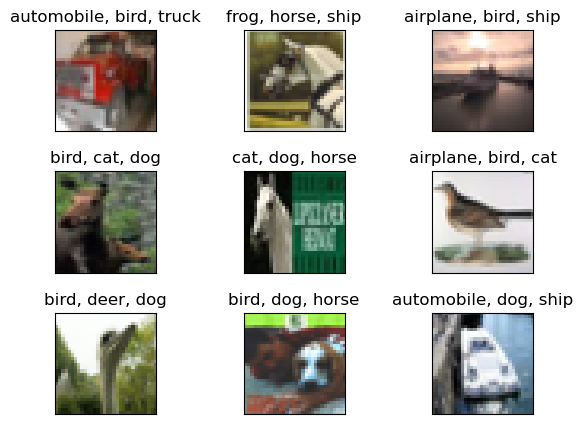

In [111]:
for i in range(9):
  ax1 = plt.subplot(330 + 1 + i)
  ll = [x for x in np.where((A_test_cp[list_cp3[i]] < threshold))][0]
  ll = ", ".join([class_names[x] for x in ll])
  ax1.title.set_text(ll)
  ax1.set_xticks([])
  ax1.set_yticks([])
  plt.imshow(images_test_cp[list_cp3[i]], cmap=plt.get_cmap('gray'))
  #plt.grid(False)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4) 


plt.show()

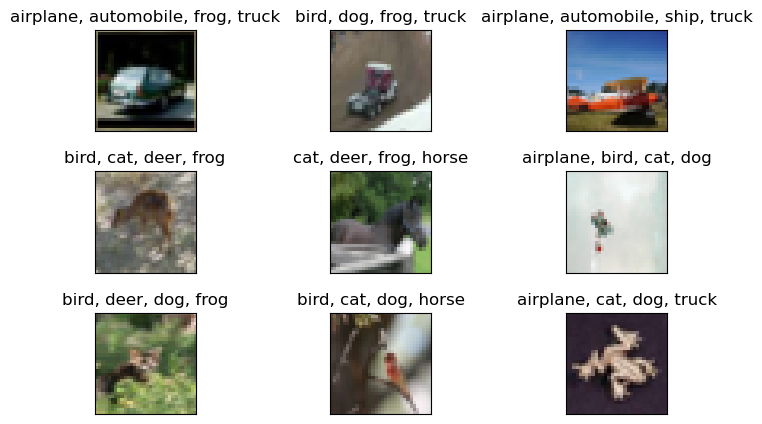

In [114]:
for i in range(9):
  ax1 = plt.subplot(330 + 1 + i)
  ll = [x for x in np.where((A_test_cp[list_cp4[i]] < threshold))][0]
  ll = ", ".join([class_names[x] for x in ll])
  ax1.title.set_text(ll)
  ax1.set_xticks([])
  ax1.set_yticks([])
  plt.imshow(images_test_cp[list_cp4[i]], cmap=plt.get_cmap('gray'))
  #plt.grid(False)
plt.subplots_adjust(left=0.0,
                    bottom=0.1,
                    right=1.0,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4) 


plt.show()

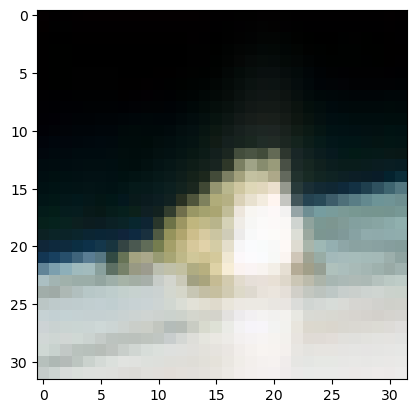

In [115]:
plt.imshow(images_test_cp[list_cp5[0]], cmap=plt.get_cmap('gray'))
plt.show()

In [117]:
ll = [x for x in np.where((A_test_cp[list_cp5[0]] < threshold))][0]
ll = ", ".join([class_names[x] for x in ll])
ll

'bird, cat, deer, horse, ship'